In [1]:
import torch
import sbibm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import csv
import copy
import pickle
from rdkit import Chem
from rdkit.Chem import AllChem, TorsionFingerprints

import py3Dmol

sns.set_theme()

In [2]:
mpl.rcParams['text.usetex'] = True
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsfonts}'

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
with open("full_scores.pkl", "rb") as f:
    results = pickle.load(f)
results = np.array(results)

In [4]:
calibration_size = 500
calibration_scores = results[:calibration_size].flatten()
test_scores = results[calibration_size:].flatten()

In [5]:
desired_coverages = np.arange(0.05, 1.0, 0.025)
quantiles = np.quantile(calibration_scores, q = desired_coverages)
contained = np.tile(test_scores, (len(quantiles), 1)).T < np.tile(quantiles, (len(test_scores), 1))

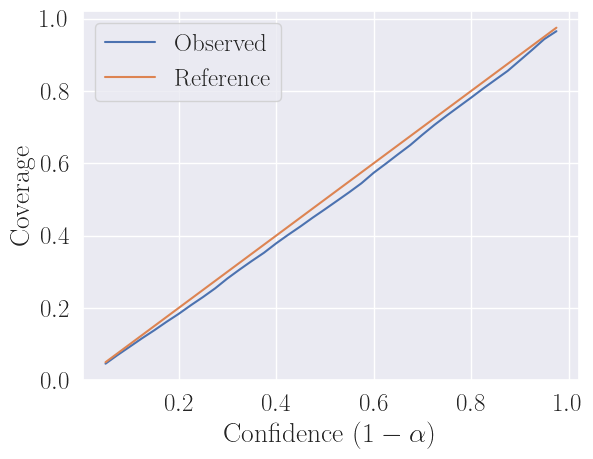

In [6]:
coverages = contained.mean(axis=0)
sns.lineplot(x=desired_coverages, y=coverages, label="Observed")
sns.lineplot(x=desired_coverages, y=desired_coverages, label="Reference")
plt.xlabel(r"Confidence $(1-\alpha)$",fontsize=20)
plt.ylabel("Coverage",fontsize=20)
plt.legend()

In [7]:
quantile = np.quantile(calibration_scores, q = 0.95)

In [8]:
import sys
import os
import argparse
import multiprocessing as mp
import platform
import warnings

import cv2
import mmcv
import torch
from mmcv import Config, DictAction
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmcv.runner import get_dist_info, init_dist, load_checkpoint

from mmgen.apis import set_random_seed
from mmgen.core import build_metric
from mmgen.datasets import build_dataset
from mmgen.models import build_model
from mmgen.utils import get_root_logger
from lib.apis import evaluate_3d
from lib.datasets import build_dataloader
from lib.datasets.shapenet_srn import ShapeNetSRN
import pickle
import cv2
import matplotlib.pyplot as plt
from mmcv import Config, DictAction

import lpips
import numpy as np
import copy

srn_dir = "/home/yppatel/csi/nerf/data/shapenet/cars_test"
data_loader = ShapeNetSRN(srn_dir)

config_fn = "/home/yppatel/csi/nerf/configs/paper_cfgs/ssdnerf_cars_recons1v.py"
cfg = Config.fromfile(config_fn)
model = build_model(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg).to("cuda:0")
model.eval()

ckpt = "/home/yppatel/csi/nerf/ssdnerf_cars_recons1v_80k_emaonly.pth"
load_checkpoint(model, ckpt, map_location='cuda')

lpips_eval = lpips.LPIPS(net='vgg').to("cuda:0")
lpips_eval.eval()

2023-08-12 11:07:22,065 - mmgen - INFO - Apply 'timestep_weight' rescale_mode for loss_ddpm_mse. Please make sure the passed weight can be updated by external functions.


load checkpoint from local path: /home/yppatel/csi/nerf/ssdnerf_cars_recons1v_80k_emaonly.pth
The model and loaded state dict do not match exactly

missing keys in source state_dict: decoder.aabb, decoder.base_net.0.weight, decoder.base_net.0.bias, decoder.density_net.0.weight, decoder.density_net.0.bias, decoder.dir_net.0.weight, decoder.dir_net.0.bias, decoder.color_net.0.weight, decoder.color_net.0.bias, diffusion.denoising.time_embedding.blocks.0.weight, diffusion.denoising.time_embedding.blocks.0.bias, diffusion.denoising.time_embedding.blocks.2.weight, diffusion.denoising.time_embedding.blocks.2.bias, diffusion.denoising.in_blocks.0.0.weight, diffusion.denoising.in_blocks.0.0.bias, diffusion.denoising.in_blocks.1.0.conv_1.0.weight, diffusion.denoising.in_blocks.1.0.conv_1.0.bias, diffusion.denoising.in_blocks.1.0.conv_1.2.weight, diffusion.denoising.in_blocks.1.0.conv_1.2.bias, diffusion.denoising.in_blocks.1.0.norm_with_embedding.norm.weight, diffusion.denoising.in_blocks.1.0.no

/home/yppatel/anaconda3/envs/chig/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yppatel/anaconda3/envs/chig/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/yppatel/anaconda3/envs/chig/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


LPIPS(
  (scaling_layer): ScalingLayer()
  (net): vgg16(
    (slice1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (slice2): Sequential(
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
    )
    (slice3): Sequential(
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, 

In [9]:
idx = 0
sample_test_pts = []
for original_data in data_loader:
    idx += 1
    if idx > calibration_size:
        sample_test_pts.append(original_data)
    else:
        continue
    if len(sample_test_pts) == 5:
        break

In [10]:
N = 5

original_data = sample_test_pts[1] # choose a single *object* to predict for
cond_idx = [0,1]                    # choose a single view to predict *with*
test_idx = [100,101]                # choose a single view to predict *to*

original_data["cond_poses"] = original_data["cond_poses"].unsqueeze(0)
original_data["cond_intrinsics"] = original_data["cond_intrinsics"].unsqueeze(0)
original_data["cond_imgs"] = original_data["cond_imgs"].unsqueeze(0)

data = copy.deepcopy(original_data)
data["cond_poses"] = original_data["cond_poses"][:,cond_idx[0]:cond_idx[1],...].to("cuda:0")
data["cond_intrinsics"] = original_data["cond_intrinsics"][:,cond_idx[0]:cond_idx[1],...].to("cuda:0")
data["cond_imgs"] = original_data["cond_imgs"][:,cond_idx[0]:cond_idx[1],...].to("cuda:0")

data["test_poses"] = original_data["cond_poses"][:,test_idx[0]:test_idx[1],...].to("cuda:0")
data["test_intrinsics"] = original_data["cond_intrinsics"][:,test_idx[0]:test_idx[1],...].to("cuda:0")

# note: this *cannot* be easily vectorized, since the randomness in drawing a new sample from the model is in the construction of the NeRF *not*
# in the final render)
samples_per_cp_score = 10 + N
test_samples = []
for _ in range(samples_per_cp_score):
    outputs_dict = model.val_step(data)
    test_pred_img = outputs_dict["pred_imgs"][0,...]
    test_samples.append(test_pred_img)

In [11]:
score_samples = test_samples[:10]
traj_inits = test_samples[10:]

In [12]:
from skimage import exposure

def feature_match_img(proposal_img, target_features):
    learning_rate = .05
    target_img = proposal_img.clone()
    target_img.requires_grad_(True)
    optimizer = torch.optim.RMSprop([target_img], lr=learning_rate)

    optim_steps = 100 # steps for local feature inversion hill climbing
    for step in range(optim_steps):
        with torch.no_grad():
            target_img.clamp_(0, 1)

        optimizer.zero_grad()
        loss = lpips_eval(target_img, target_features, retPerLayer=False, featurized0=False, featurized1=True).squeeze()
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        target_img.clamp_(0, 1)

    to_img = lambda x : np.transpose(x[0].cpu().detach().numpy(), (1, 2, 0))

    src = to_img(proposal_img)
    raw_target = to_img(target_img.clone().detach())
    raw_target[src == 1] = 1

    final_target = exposure.match_histograms(raw_target, src)
    final_target = torch.permute(torch.Tensor(final_target), dims=(2, 0, 1)).unsqueeze(0).cuda()
    return final_target

In [17]:
trajs = []
for n in range(N):
    eta = 0.01
    T   = 100
    traj = []

    current_img = traj_inits[n].clone()
    _, _, current_iter, _ = lpips_eval(current_img, current_img, retPerLayer=True) # dummy call to get featurized representation -- will serve as feature target
    for t in range(T):
        proposal_iter = current_iter.copy()

        feature = 4 # only jitter final feature for now (kinda ratchet)
        perturbation = torch.randn_like(proposal_iter[feature])
        proposal_iter[feature] = proposal_iter[feature] + eta * perturbation

        # proposal_img = feature_match_img(current_iter, target_features)
        
        lpip_evals = []
        for sample_idx in range(len(score_samples)):
            lpip_eval = lpips_eval(score_samples[sample_idx], proposal_iter, featurized0=False, featurized1=True).cpu().detach().numpy().flatten()
            lpip_evals.append(lpip_eval)

        proposal_score = np.min(lpip_evals)
        if proposal_score < quantile:
            traj.append(copy.deepcopy(proposal_iter))
            current_iter = proposal_iter
    trajs.append(traj)
    print(f"Acceptance rate: {len(traj) / T}")

Acceptance rate: 0.19
Acceptance rate: 0.19
Acceptance rate: 0.14
Acceptance rate: 0.22
Acceptance rate: 0.19


In [23]:
import sklearn

def RPs(traj, N):
    """Computational component for initialization of n_clusters by
    k-means++. Prior validation of data is assumed.

    Parameters
    ----------
    X : {ndarray, sparse matrix} of shape (n_samples, n_features)
        The data to pick seeds for.

    n_clusters : int
        The number of seeds to choose.

    Returns
    -------
    centers : ndarray of shape (n_clusters, n_features)
        The initial centers for k-means.
    """
    # Pick first center randomly and track index of point
    centers = []
    centers.append(traj[np.random.choice(len(traj))])
    
    # Initialize list of closest distances and calculate current potential
    sq_dist = lambda x, y : lpips_eval(x, y, featurized0=True, featurized1=True).cpu().detach().numpy().flatten()[0] ** 2
    closest_dist_sq = [sq_dist(x, centers[0]) for x in traj]
    
    # Pick the remaining n_clusters-1 points
    n_local_trials = 10 # 2 + int(np.log(N))
    for _ in range(1, N):
        weighted_p = closest_dist_sq / np.sum(closest_dist_sq)
        candidates = np.random.choice(traj, size=n_local_trials, replace=True, p=weighted_p)

        # Compute distances to center candidates
        distance_to_candidates = np.array([[sq_dist(x, candidate) for x in traj] for candidate in candidates])
        np.minimum(closest_dist_sq, distance_to_candidates, out=distance_to_candidates)
        distances = np.sum(distance_to_candidates, axis=1)

        # Decide which candidate is the best
        best_candidate_idx = np.argmin(distances)
        closest_dist_sq = distance_to_candidates[best_candidate_idx]
        best_candidate = candidates[best_candidate_idx]

        # Permanently add best center candidate found in local tries
        centers.append(best_candidate)

    return centers

In [24]:
centers = [RPs(traj, N=2)[-1] for traj in trajs]

In [27]:
rp_imgs = [feature_match_img(traj_init, center) for traj_init, center in zip(traj_inits, centers)]

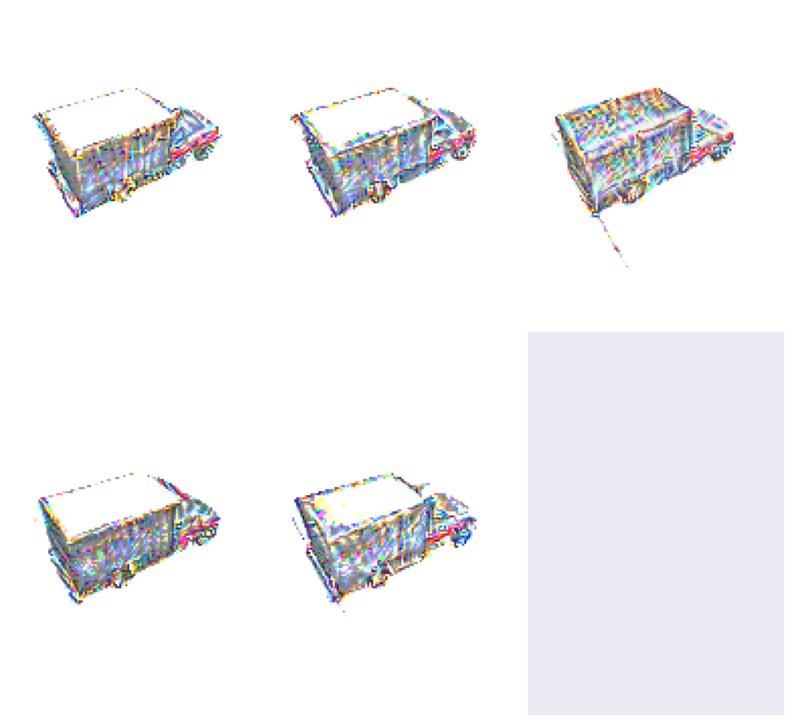

In [32]:
to_img = lambda x : np.transpose(x[0].cpu().detach().numpy(), (1, 2, 0))
plt.rcParams["figure.figsize"] = [10, 10]

f, axs = plt.subplots(2, 3)
axs[0,0].imshow(to_img(rp_imgs[0]))
axs[0,1].imshow(to_img(rp_imgs[1]))
axs[0,2].imshow(to_img(rp_imgs[2]))
axs[1,1].imshow(to_img(rp_imgs[3]))
axs[1,0].imshow(to_img(rp_imgs[4]))

# remove the x and y ticks
for ax_i in axs:
    for ax in ax_i:
        ax.set_xticks([])
        ax.set_yticks([])

plt.subplots_adjust(wspace=0, hspace=0)
plt.rcParams["axes.grid"] = False

In [47]:
center_idx = 2
center = centers[center_idx]
traj = trajs[center_idx]

traj_imgs = [feature_match_img(traj_inits[center_idx], traj_features) for traj_features in traj]
center_img = feature_match_img(traj_inits[center_idx], center)

In [48]:
proj_imgs = []
for traj_img in traj_imgs:
    proj_dists = []
    _, _, width, height = traj_img.shape
    proj_img = np.zeros((width, height))
    for col in range(width):
        for row in range(height):
            perturbed_center = copy.deepcopy(center_img)
            perturbed_center[:,:,row,col] = traj_img[:,:,row,col]
            proj_img[row,col] = lpips_eval(perturbed_center, center_img)
    proj_imgs.append(proj_img)
proj_imgs = np.array(proj_imgs)

In [49]:
proj_imgs = np.array(proj_imgs)
frechet_var = proj_imgs.mean(axis=0)

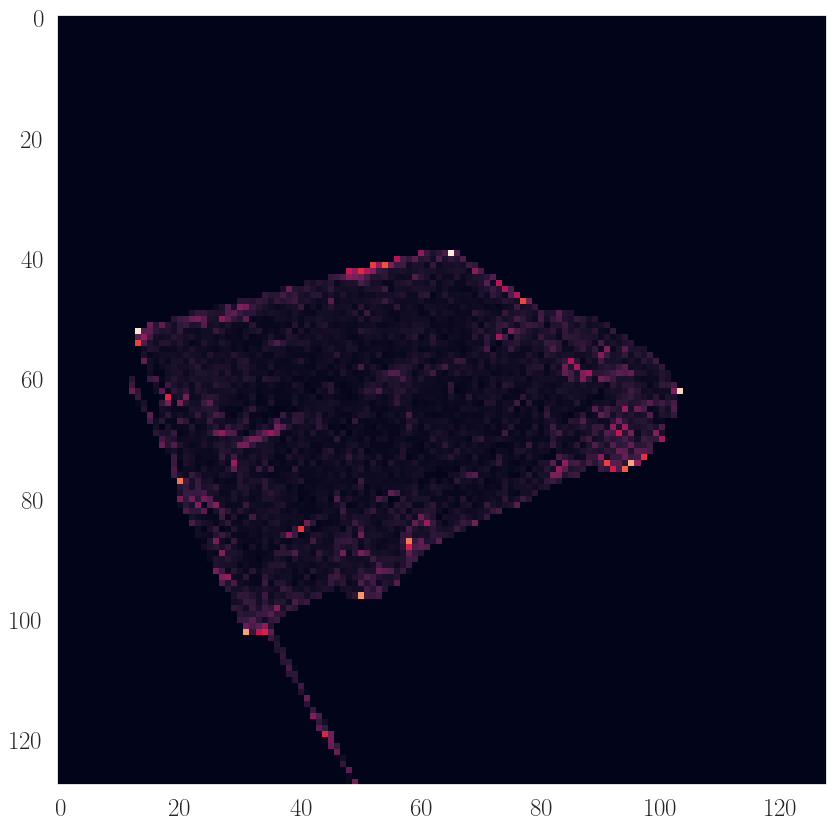

In [50]:
plt.imshow(frechet_var)

In [51]:
frechet_var0 = np.load("var0.npy")
frechet_var1 = frechet_var.copy()

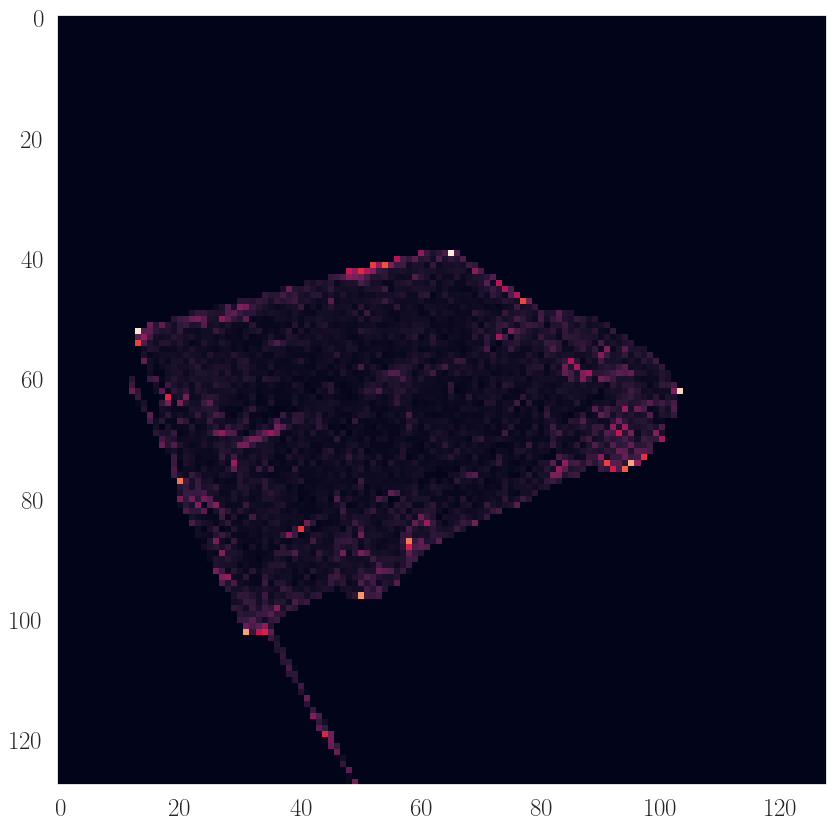

In [57]:
plt.imshow(frechet_var1)

In [60]:
blurred_var0 = cv2.GaussianBlur(frechet_var0, (3, 3), 0)
scaled_var0 = (blurred_var0 - blurred_var0.min()) / blurred_var0.max()

blurred_var1 = cv2.GaussianBlur(frechet_var1, (3, 3), 0)
scaled_var1 = (blurred_var1 - blurred_var1.min()) / blurred_var1.max()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

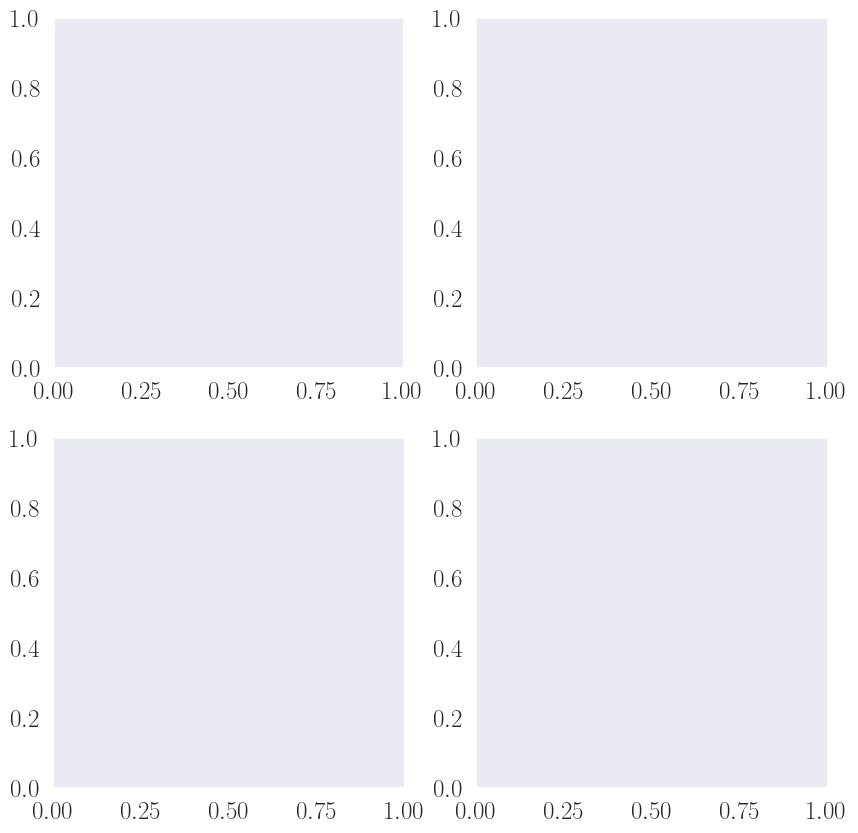

In [61]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

to_img = lambda x : np.transpose(x[0].cpu().detach().numpy(), (1, 2, 0))
plt.rcParams["figure.figsize"] = [10, 10]

f, axs = plt.subplots(2, 2)
axs[0,0].imshow(to_img(rp_imgs[0]))
vars_im0 = axs[0,1].imshow(scaled_var0)
axs[1,0].imshow(to_img(rp_imgs[2]))
vars_im1 = axs[1,1].imshow(scaled_var1)

# remove the x and y ticks
for ax_i in axs:
    for ax in ax_i:
        ax.set_xticks([])
        ax.set_yticks([])

divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(vars_im0, cax=cax, orientation='vertical')

divider = make_axes_locatable(axs[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(vars_im1, cax=cax, orientation='vertical')

plt.subplots_adjust(wspace=0, hspace=0)
plt.rcParams["axes.grid"] = False